In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load data

In [2]:
W_list = [1,10,20,30,40]
filename_list = np.genfromtxt('./20230804_desmearedData/FileNames.txt',dtype='str')

In [64]:
import os
n_des = 1
## load desmeared D22 data
data_path = './20230804_desmearedData/'
data_list = []
data_list_6 = []
for i in range(5):
    filename = '{}_des{}.txt'.format(6+i,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list.append(data)

    filename = '{}_des{}.txt'.format(1+i,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list_6.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

In [65]:
def unpack_data(data):
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    return Q, IQ, IQ_er

## Plot data

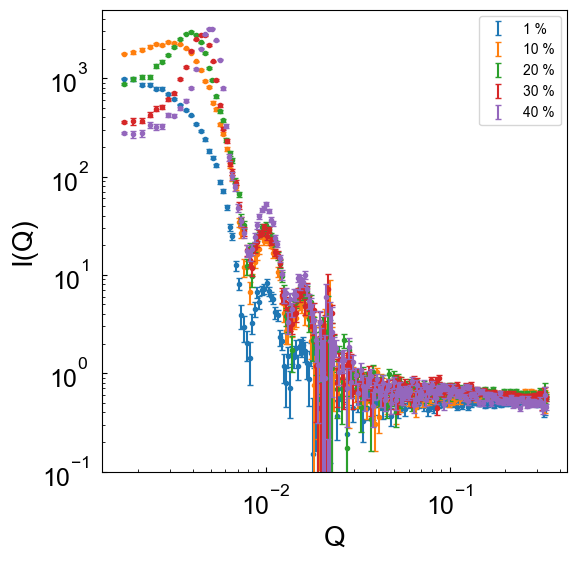

In [66]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = ['C0','C1','C2','C3','C4']
for i, W in enumerate(W_list):
    dataname = '{} %'.format(W)
    data = data_list[i]
    Q, IQ, IQ_er = unpack_data(data)
    ax.plot(Q,IQ,'.', color = colors[i])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i] ,capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_ylim([0.1,5000])
ax.set_xlabel('Q',fontsize=20)
ax.set_ylabel('I(Q)',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()
plt.show()

## Define function

In [67]:
## fit desmeared D22 dilute data for form factor

# fit P(Q)
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def fuzzysphere(q,sigma=1,sigma_f=0.1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2*np.exp(-(sigma_f*sigma*q)**2/2)
    return P

def log_normal_pdf(mu,sigma,x):
    return np.exp(-(np.log(x)-mu)**2/2/sigma**2)/x/sigma

def P_HS_eff(q,sigma=1,d_sigma=0.05):
    n_sample = 101
    sigma_list = (1+np.linspace(-5,5,n_sample)*d_sigma)*sigma
    # p_sigma = np.exp(np.linspace(-3,3,n_sample)**2/2)*(sigma_list)**6
    p_sigma = log_normal_pdf(0,d_sigma,sigma_list/sigma)*(sigma_list)**6
    # var = d_sigma**2
    # k = 1/var
    # x = (1+np.linspace(-3,3,n_sample)*d_sigma)
    # p_sigma = k**k*x**(k-1)*np.exp(-k*x)/gamma(k)

    P_eff = np.zeros_like(q)

    for i in range(n_sample):
        P_i = hardsphere(q,sigma_list[i])*p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff/np.sum(p_sigma)

    return P_eff

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out # sampled on Q

def I_P(Q, dQ, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    Q_fine = Q
    P_res = IQ_resoln(Q,Q_fine,P,dQ)
    f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    P = f_interp(Q)

    return A*P + I_inc    

def I_P_d(Q, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    # Q_fine = Q
    # P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    # f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    # P = f_interp(Q)

    return A*P + I_inc    

## Fit form factor

In [68]:
# 1%
data = data_list[0]
Q, IQ, IQ_er = unpack_data(data)
IQ_P = IQ
IQ_er_P = IQ_er

# remove extreme values
index_extreme = IQ<0.4
Q = np.delete(Q,index_extreme)
IQ = np.delete(IQ,index_extreme)
IQ_er = np.delete(IQ_er,index_extreme)

# initialize parameters
params = Parameters()
params.add('sigma', value=1500, min=1100, max=1300)
params.add('A', value=1e3, min=5e2, max=1.5e3)
params.add('I_inc', value=0.8, min=0.5, max=1)
params.add('d_sigma', value=0.08, min=0.005, max=0.15)

index_Q = (Q>1e-3)*(Q<5e-1)
# loss function for fitting form factor
def lambda_P(params, Q, IQ_exp, index_Q):
    v = params.valuesdict()
    return (((I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])) 
           - (IQ_exp))/IQ_er**2)[index_Q]

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_P, params, fcn_args=(Q, IQ, index_Q))
result_P = minner.minimize(method='nedler')

# fitted curve
v = result_P.params.valuesdict()
IQ_fit = I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])

# write error report
report_fit(result_P)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 657
    # data points      = 186
    # variables        = 4
    chi-square         = 122114.166
    reduced chi-square = 670.956954
    Akaike info crit   = 1214.57549
    Bayesian info crit = 1227.47848
[[Variables]]
    sigma:    1151.43470 +/- 80.6915482 (7.01%) (init = 1300)
    A:        1218.17789 +/- 582.614096 (47.83%) (init = 1000)
    I_inc:    0.50833782 +/- 0.00182264 (0.36%) (init = 0.8)
    d_sigma:  0.06085888 +/- 0.06643250 (109.16%) (init = 0.08)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, d_sigma) = -0.4113
    C(sigma, A)       = +0.3687


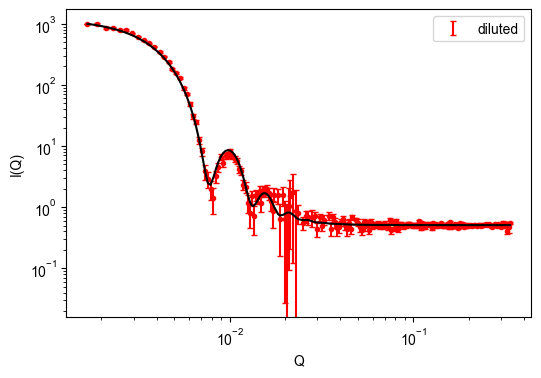

In [69]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.r')
ax.errorbar(Q,IQ,IQ_er,linestyle='',label='diluted',color='r',capsize=2)
# ax.plot(Q_p,IQ_data_p,'.m',label='diluted')
ax.plot(Q[index_Q],IQ_fit,'-k',zorder=3)
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 178
    # variables        = 2
    chi-square         = 55556.9606
    reduced chi-square = 315.664549
    Akaike info crit   = 1026.32174
    Bayesian info crit = 1032.68530
[[Variables]]
    A:      6909.29376 +/- 2213.46058 (32.04%) (init = 10000)
    I_inc:  0.61148423 +/- 0.00303933 (0.50%) (init = 0.5)


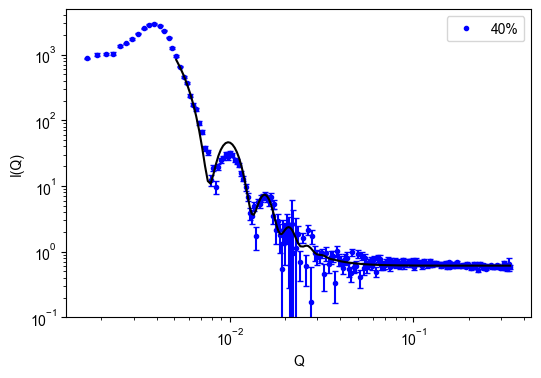

In [70]:
# 20%
data = data_list[2]
Q, IQ, IQ_er = unpack_data(data)
IQ_I = IQ
IQ_er_I = IQ_er

# # remove extreme values
# index_extreme = (Q>0.022) & (Q<0.023)
# Q = np.delete(Q,index_extreme)
# IQ = np.delete(IQ,index_extreme)
# IQ_er = np.delete(IQ_er,index_extreme)

# loss function for fitting form factor
def lambda_I(params, Q, IQ_exp, index_Q):
    v = params.valuesdict()
    return (((I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)) 
           - (IQ_exp))/IQ_er**2)[index_Q]

sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=1e4, min=2e2, max=2e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q>5e-3)*(Q<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q, IQ, index_Q))
result_I = minner.minimize()

# fitted curve
v = result_I.params.valuesdict()
IQ_fit = I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)

# write error report
report_fit(result_I)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.b',label='{}%'.format(W))
ax.errorbar(Q,IQ,IQ_er,linestyle='',color='b',capsize=2)
ax.plot(Q[index_Q],IQ_fit[index_Q],'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

C:\Users\wagen\AppData\Local\Temp\ipykernel_67116\4072754958.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,20])


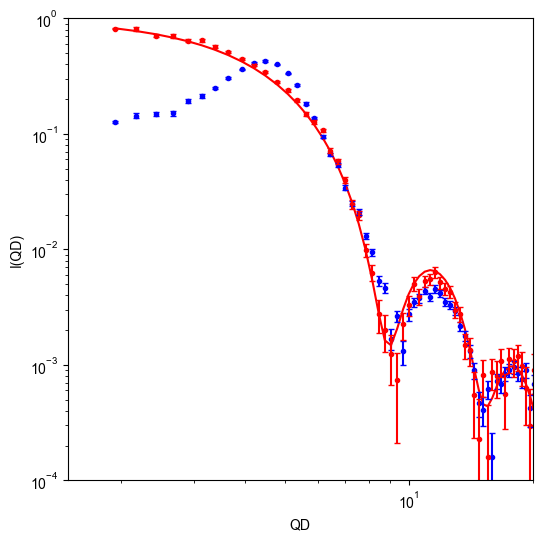

In [71]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_P_scaled = (IQ_P-fp_opt_P['I_inc'])/fp_opt_P['A']
IQ_I_scaled = (IQ_I-fp_opt_I['I_inc'])/fp_opt_I['A']
IQ_er_P_scaled = (IQ_er_P)/fp_opt_P['A']
IQ_er_I_scaled = (IQ_er_I)/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q*fp_opt_P['sigma'],IQ_I_scaled,'.b')
ax.plot(Q*fp_opt_P['sigma'],IQ_P_scaled,'.r')
ax.plot(Q*fp_opt_P['sigma'], I_P_d(Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-r')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I_scaled,IQ_er_I_scaled,
            linestyle='',color='b',capsize=2)
ax.errorbar(Q*fp_opt_P['sigma'],IQ_P_scaled,IQ_er_P_scaled,
            linestyle='',color='r',capsize=2)


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,20])
ax.set_ylim([1e-4,1])
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
# ax.legend()
plt.show()

C:\Users\wagen\AppData\Local\Temp\ipykernel_67116\366021770.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,20])
C:\Users\wagen\AppData\Local\Temp\ipykernel_67116\366021770.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,3])


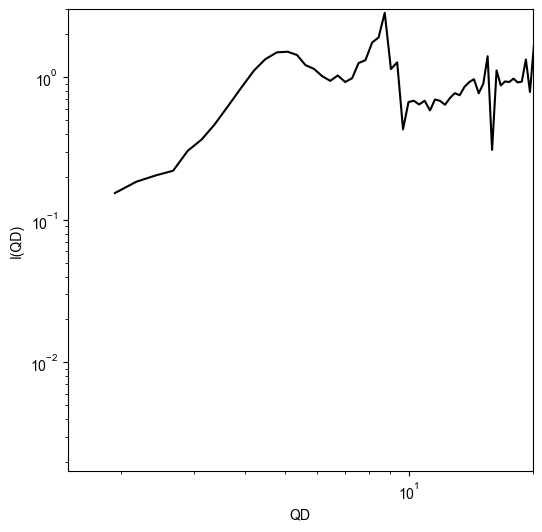

In [72]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_0 = (IQ-fp_opt_I['I_inc'])/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
# ax.plot(Q,IQ_0,'.b',label='600')
ax.plot(Q*fp_opt_P['sigma'], 
        IQ_0/I_P_d(Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,20])
ax.set_ylim([0,3])
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
plt.show()

## Fit structure factor

In [73]:
'''
convert the input data to the same 80-D array as SQ-NN model
Q: Experimental scattering vector 
q: Rescaled Q
sq_dim: Dimension of rescaled q
'''
## Interpolate data
sq_dim = 80
sample_dim = 1
q = (np.arange(sq_dim)+1)*0.2

## The input data is rescaled to the range such that 0.02<=QD<=16 
r_HS_i = fp_opt_P['sigma']/2 # from form factor fitting
d_HS_i = r_HS_i*2
print('Initial guess of d_HS = {}'.format(d_HS_i))
IQ_rs = np.zeros((sample_dim,sq_dim)) 
Qd_HS = Q*d_HS_i

## rescale IQ to QD in [0,16]
f_IQ = interp.interp1d(Qd_HS,IQ_I,fill_value='extrapolate')
IQ_rs = f_IQ(q).astype(np.float32)
IQ_rs[IQ_rs<=0] = 1e-5

## rescale IQ_er to QD in [0,16]
f_IQ_er = interp.interp1d(Qd_HS,IQ_er_I,fill_value='extrapolate',kind='nearest')
IQ_er_rs = f_IQ_er(q).astype(np.float32)
# IQ_er_rs[IQ_er_rs<=0] = 1e-5

Initial guess of d_HS = 1151.4347035441897


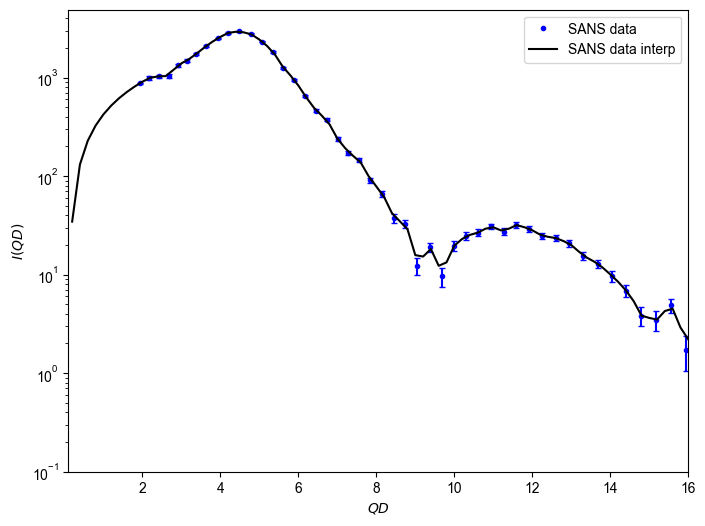

In [74]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Q*fp_opt_P['sigma'],IQ_I,'.b',label='SANS data')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I,IQ_er_I,linestyle='',color='b',capsize=2)
ax.plot(q,IQ_rs,'-k',label='SANS data interp')
ax.set_xlim([0.1,16])
# ax.set_ylim([0.1,30])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

In [75]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=1)

In [79]:
# initialize parameters
params = Parameters()
params.add('C', value=4800, min=1e2, max=5e4)
params.add('I_inc', value=fp_opt_I['I_inc'], min=0.1, max=2)
params.add('sigma', value=0.975, min=0.9, max=1.1)
params.add('d_sigma', value=fp_opt_P['d_sigma'], min=0.005, max=0.1)

fp_i =       [0.15, 0.15,  11]
fp_ubounds = (0.5,  0.18,  20)
fp_lbounds = (0.05, 0.1,  0.5)
fp_name = ['phi', 'kappa', 'A']
for i in range(3):
    params.add(fp_name[i], value=fp_i[i], min=fp_ubounds[i], max=fp_lbounds[i])

def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],v['A'],1]

    # structure factor
    S = SQ_NN(fp[0:3])
    S = savgol_filter(S,7,2)

    # form factor
    P = P_HS_eff(Q,sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*P*S + v['I_inc']
    return I

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (x-y)/z
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])

# do fit, here with the Nedler algorithm
index_Q = (q>2)*(q<16)
minner = Minimizer(lmbda, params, fcn_args=(q, IQ_rs, IQ_er_rs, index_Q))
result = minner.minimize(method='nedler')

# write error report
report_fit(result)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1339
    # data points      = 69
    # variables        = 7
    chi-square         = 720.611172
    reduced chi-square = 11.6227608
    Akaike info crit   = 175.873531
    Bayesian info crit = 191.512276
[[Variables]]
    C:        6380.22932 +/- 141.460237 (2.22%) (init = 4800)
    I_inc:    0.86180891 +/- 0.60362891 (70.04%) (init = 0.6114842)
    sigma:    0.97286556 +/- 0.00583560 (0.60%) (init = 0.975)
    d_sigma:  0.07121961 +/- 0.00720020 (10.11%) (init = 0.06085888)
    phi:      0.14315688 +/- 2.9804e-04 (0.21%) (init = 0.15)
    kappa:    0.15391089 +/- 1.0199e-04 (0.07%) (init = 0.15)
    A:        10.8040097 +/- 0.01381387 (0.13%) (init = 11)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, kappa)     = +0.6027
    C(sigma, d_sigma) = -0.4985
    C(C, sigma)       = +0.4035
    C(C, d_sigma)     = +0.3853
    C(I_inc, d_sigma) = -0.3267
    C(I_inc, sigma)   = +0.3144
    C(C,

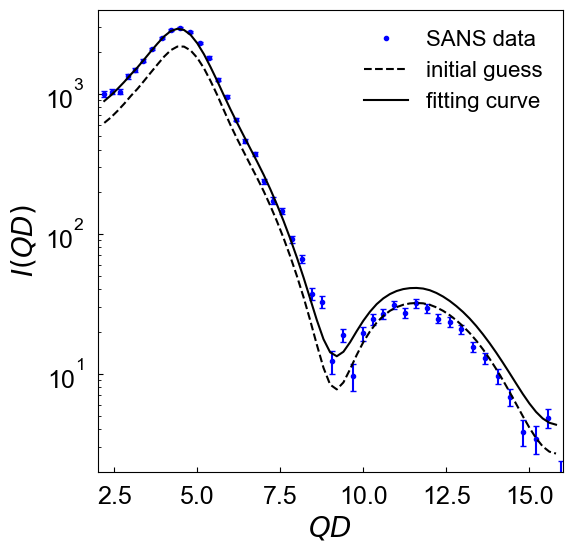

In [81]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Q*fp_opt_P['sigma'],IQ_I,'.b',label='SANS data')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I,IQ_er_I,linestyle='',color='b',capsize=2)
ax.plot(q[index_Q], IQ_th(params,q)[index_Q],'--k',label='initial guess')
ax.plot(q[index_Q], IQ_th(result.params,q)[index_Q],'-k',label='fitting curve')

ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim([2,16])
ax.set_ylim([2,4000])
ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend(fontsize=16,frameon=False)
plt.show()